#### this documentation is outdated: https://huggingface.co/AutonLab/MOMENT-1-large
#### demo is up to date: https://github.com/moment-timeseries-foundation-model/moment/blob/main/tutorials/forecasting.ipynb
#### when importing moment, it is `momentfm` not `moment`. P.S. use python 3.11

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
!pip install numpy pandas matplotlib tqdm
!pip install git+https://github.com/moment-timeseries-foundation-model/moment.git

  Cloning https://github.com/moment-timeseries-foundation-model/moment.git to /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-req-build-wi0jzczt
  Running command git clone --filter=blob:none --quiet https://github.com/moment-timeseries-foundation-model/moment.git /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-req-build-wi0jzczt
  Resolved https://github.com/moment-timeseries-foundation-model/moment.git to commit fb620934ef6b67f878bc21b8640b22d117dbffa6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
!pip install yfinance

  Using cached yfinance-0.2.51-py2.py3-none-any.whl.metadata (5.5 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached peewee-3.17.8.tar.gz (948 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached html5lib-1.1-py2.py3-none-any.whl.metadata (16 kB)
Using cached yfinance-0.2.51-py2.py3-none-any.whl (104 kB)
Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 8.9 MB/s eta 0:00:00a 0:00:01
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
  Created wheel for peewee: filename=peewee-3.17.8-cp311-cp311-macosx_14_0_arm64.whl size=273485 sha256=30c5fa7a6f82ddd7c0b345ccb3799ba4d5d301ac3d31ab00b91fa8bd1ef30210
  Stored in directory: /Users/anthonybolton/Library/Caches/pip/wheels/ff/6c/15/506e25bc390de450a7fa53c155cd9b0fbd13ad3e84a9abc183
Successfully built peewee


# Test

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_68269/2602299598.py:16: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")
/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/moment_venv/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


Context data shape (before padding): (336, 1)
Context padded shape: (512,)
Context tensor shape: torch.Size([1, 1, 512])
Input mask shape: torch.Size([1, 512])
Number of patches: 64

Full Period Metrics:
MAE: 360.3443
MSE: 165973.2159
RMSE: 407.3981
MAPE: 6.1409
SMAPE: 6.3863
MASE: 13.1035


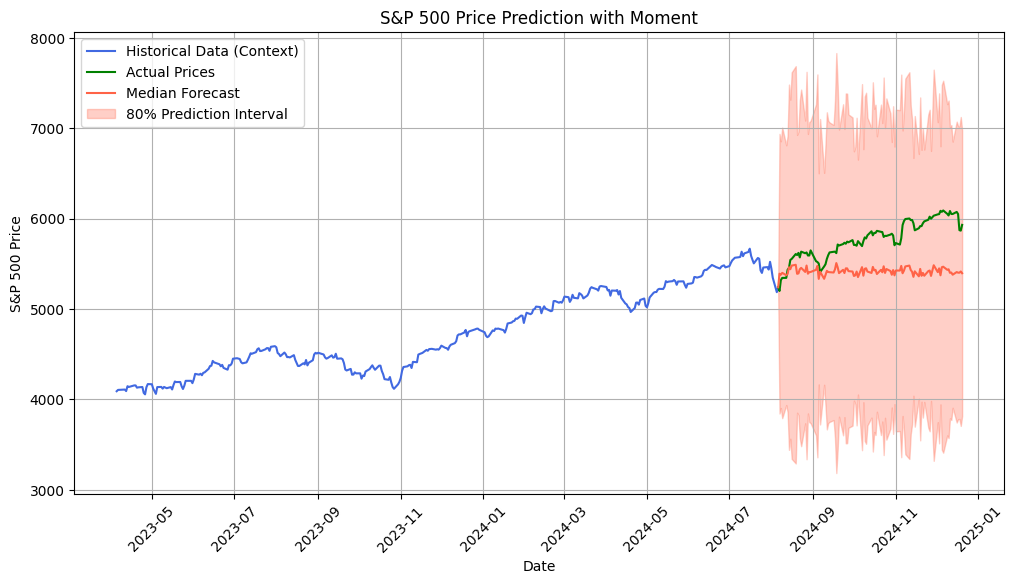

Context data shape (before padding): (336, 1)
Context padded shape: (512,)
Context tensor shape: torch.Size([1, 1, 512])
Input mask shape: torch.Size([1, 512])
Number of patches: 64

COVID Period Metrics:
MAE: 605.8630
MSE: 384678.1431
RMSE: 620.2243
MAPE: 13.2383
SMAPE: 14.2169
MASE: 21.5759


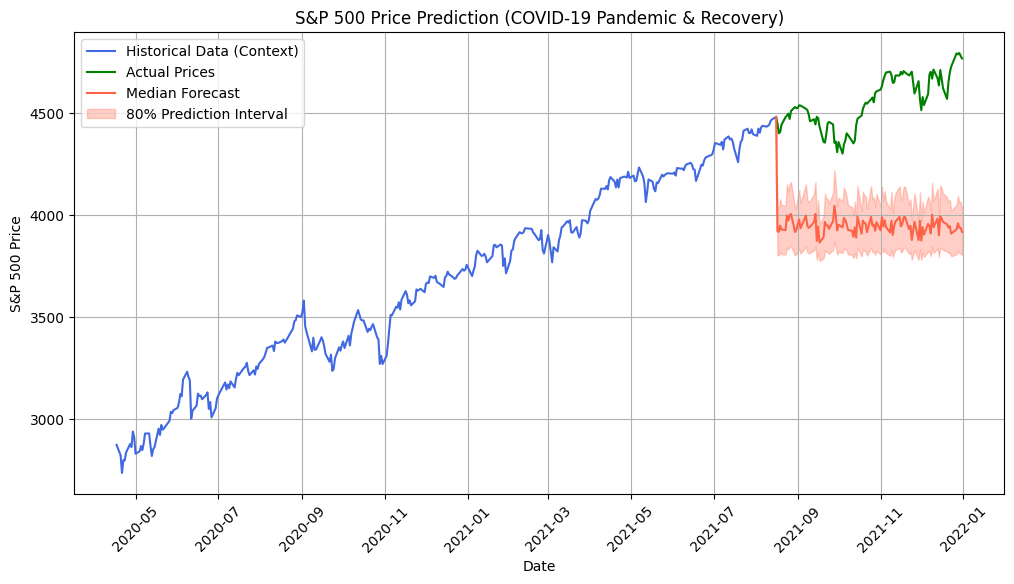

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from momentfm import MOMENTPipeline
from data.snp500 import snp500_daily
from utils.metrics import calculate_metrics
from utils.visualization import plot_forecast

CONTEXT_WINDOW = 336
PREDICTION_WINDOW = 96
PATCH_SIZE = 8  # MOMENT uses patches of size 8 by default
SEQ_LEN = 512  # Ensure sequence length matches the model's configuration

# Set device
device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")

# Initialize Moment model
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': PREDICTION_WINDOW,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True,
        'freeze_embedder': True,
        'freeze_head': False,
        'patch_size': PATCH_SIZE,
    },
)
model.init()
model = model.to(device)

# Prepare the data - using raw Close prices
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]

# Adjust patch size to match the expected input size of the model
def pad_to_patch_size(data, patch_size, seq_len):
    """Pad the input data to ensure it is divisible by patch_size and matches seq_len."""
    pad_length = max(seq_len - len(data), 0)  # Ensure length matches seq_len
    return np.pad(data, (0, pad_length), mode="edge")

# Update generate_forecast to ensure proper reshaping
def generate_forecast(context_data):
    context = np.asarray(context_data).flatten()
    context_padded = pad_to_patch_size(context, PATCH_SIZE, seq_len=SEQ_LEN)

    # Debug prints for shape verification
    print(f"Context data shape (before padding): {context_data.shape}")
    print(f"Context padded shape: {context_padded.shape}")

    # Ensure the reshaped input matches the model's expectation
    context_tensor = torch.from_numpy(context_padded).float().reshape(1, 1, -1).to(device)
    input_mask = torch.ones(context_tensor.shape[0], context_tensor.shape[2]).to(device)

    print(f"Context tensor shape: {context_tensor.shape}")
    print(f"Input mask shape: {input_mask.shape}")
    print(f"Number of patches: {context_tensor.shape[2] // PATCH_SIZE}")

    with torch.no_grad():
        model.eval()
        output = model(x_enc=context_tensor, input_mask=input_mask)
        model.train()

    mean_forecast = output.forecast.cpu().squeeze().numpy()

    # Calculate prediction intervals (as before)
    returns = np.diff(context_padded) / context_padded[:-1]
    volatility = np.std(returns)
    z_score_90 = 1.645
    interval_width = z_score_90 * volatility * mean_forecast

    low_forecast = mean_forecast - interval_width
    high_forecast = mean_forecast + interval_width

    return low_forecast, mean_forecast, high_forecast

def normalize_data(data):
    """Normalize the input data"""
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std, mean, std

def denormalize_data(data, mean, std):
    """Denormalize the data back to original scale"""
    return data * std + mean

# Generate full period forecast
context = sp500_d["Close"].values[-CONTEXT_WINDOW:]
context_norm, mean, std = normalize_data(context)
low, median, high = generate_forecast(context_norm)

# Denormalize predictions
low = denormalize_data(low, mean, std)
median = denormalize_data(median, mean, std)
high = denormalize_data(high, mean, std)

# Calculate and print metrics for full period
actual_prices = sp500_d["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_d["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_d,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with Moment",
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_d[
    (sp500_d["Date"] >= covid_start_date) & (sp500_d["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)

covid_context_norm, covid_mean, covid_std = normalize_data(covid_context)
low_covid, median_covid, high_covid = generate_forecast(covid_context_norm)

# Denormalize predictions
low_covid = denormalize_data(low_covid, covid_mean, covid_std)
median_covid = denormalize_data(median_covid, covid_mean, covid_std)
high_covid = denormalize_data(high_covid, covid_mean, covid_std)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)

# Experimenting with different context and prediction windows for different frequencies: daily, weekly, monthly


Running daily frequency experiments...


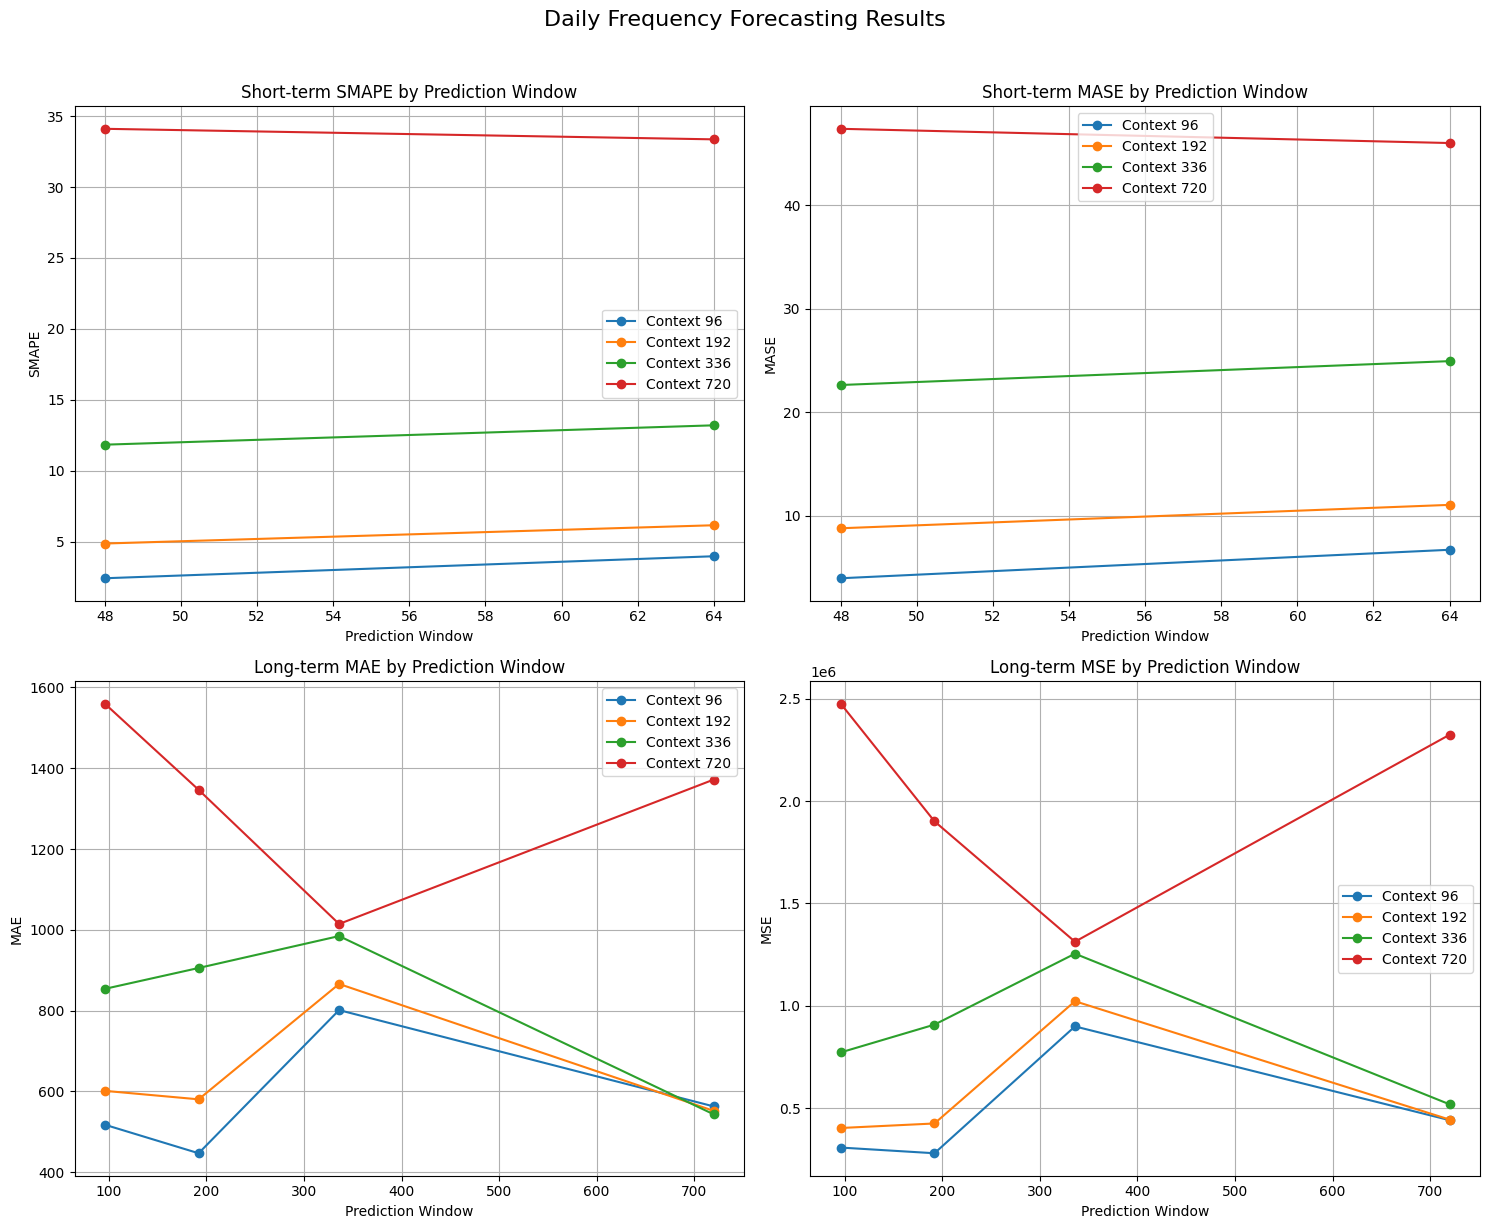


Daily Frequency Results:

Short-term Forecasting Results:
Metric                                  MAE     MAPE     MASE           MSE  \
Context Window Prediction Window                                              
96             48                  142.3391   2.3742   3.9593  2.905925e+04   
               64                  230.0814   3.8668   6.7097  6.834343e+04   
192            48                  282.4751   4.7305   8.7879  9.217521e+04   
               64                  352.4177   5.9466  11.0470  1.398052e+05   
336            48                  663.3785  11.1547  22.6253  4.536207e+05   
               64                  729.6343  12.3594  24.9307  5.492161e+05   
720            48                 1728.7363  29.1255  47.3704  3.000249e+06   
               64                 1683.7460  28.5775  45.9958  2.850823e+06   

Metric                                 RMSE    SMAPE  
Context Window Prediction Window                      
96             48                  170.4

/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/moment_venv/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


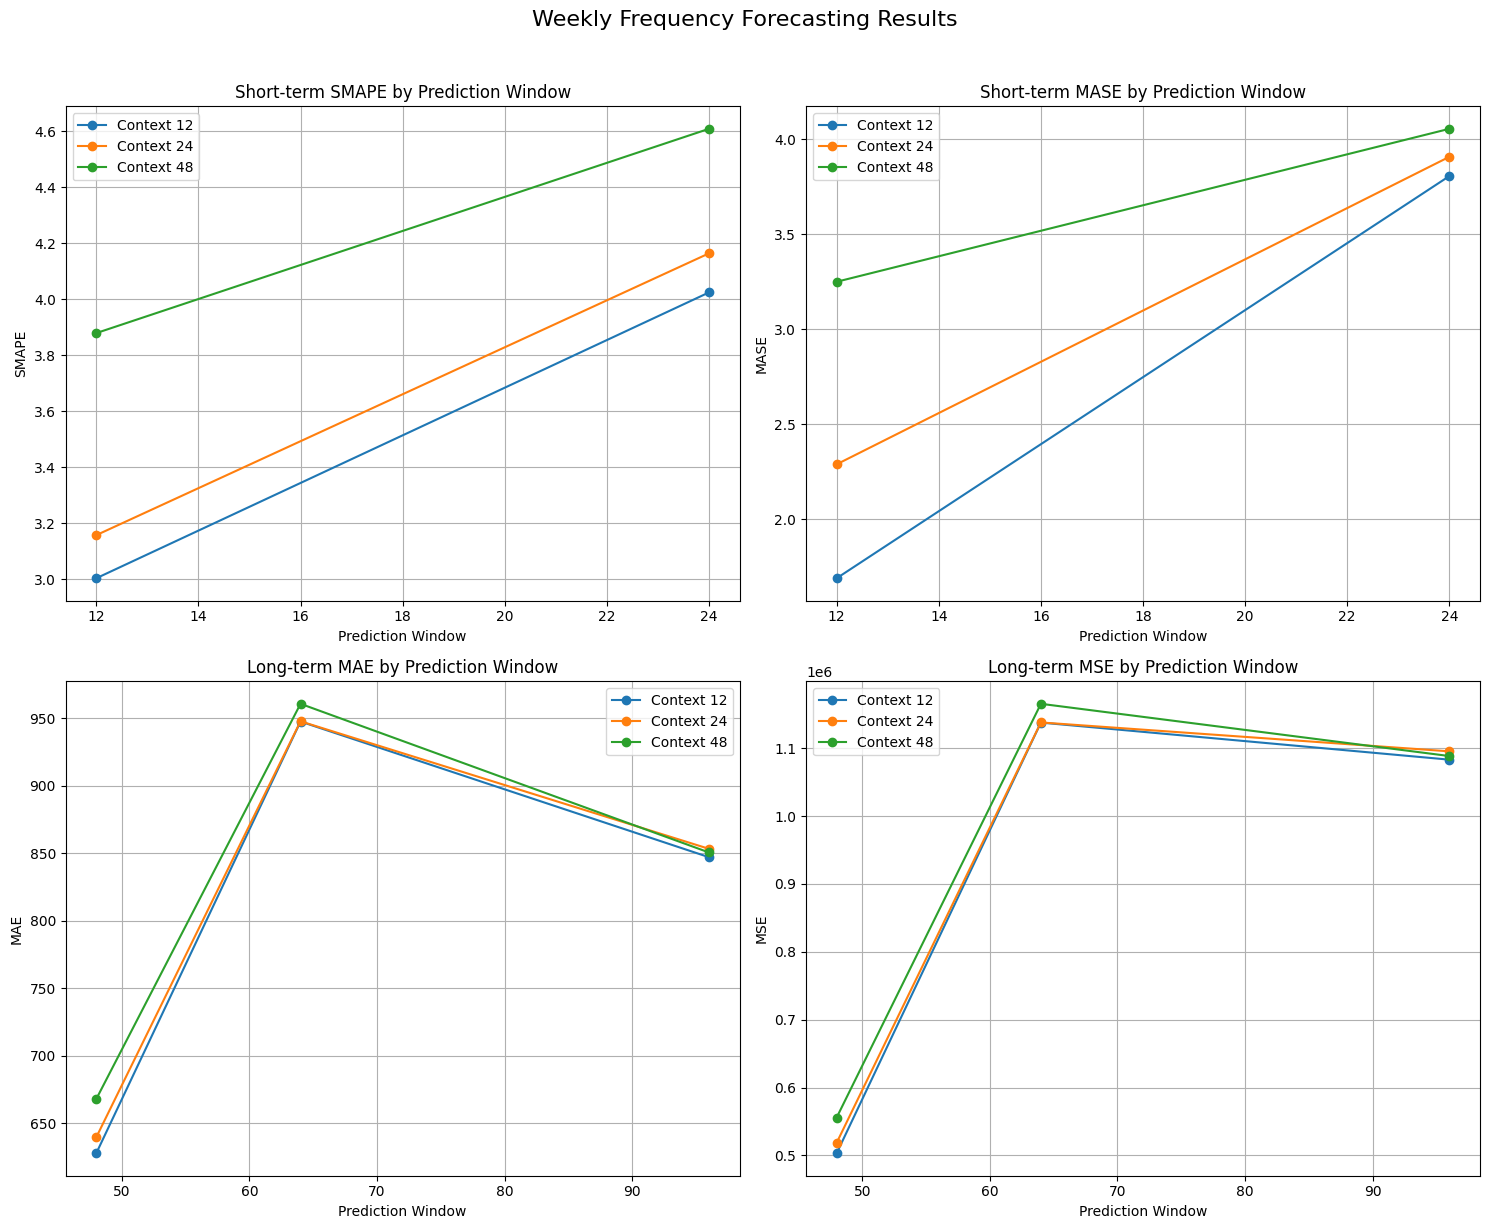


Weekly Frequency Results:

Short-term Forecasting Results:
Metric                                 MAE    MAPE    MASE         MSE  \
Context Window Prediction Window                                         
12             12                 176.0079  2.9421  1.6907  43948.1475   
               24                 229.3738  3.9310  3.8075  75471.9069   
24             12                 184.8197  3.0908  2.2904  47474.4510   
               24                 237.1220  4.0609  3.9089  80567.8249   
48             12                 225.9464  3.7868  3.2512  64638.0589   
               24                 261.6944  4.4695  4.0563  98106.3012   

Metric                                RMSE   SMAPE  
Context Window Prediction Window                    
12             12                 209.6381  3.0043  
               24                 274.7215  4.0241  
24             12                 217.8863  3.1581  
               24                 283.8447  4.1635  
48             12            

/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/moment_venv/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


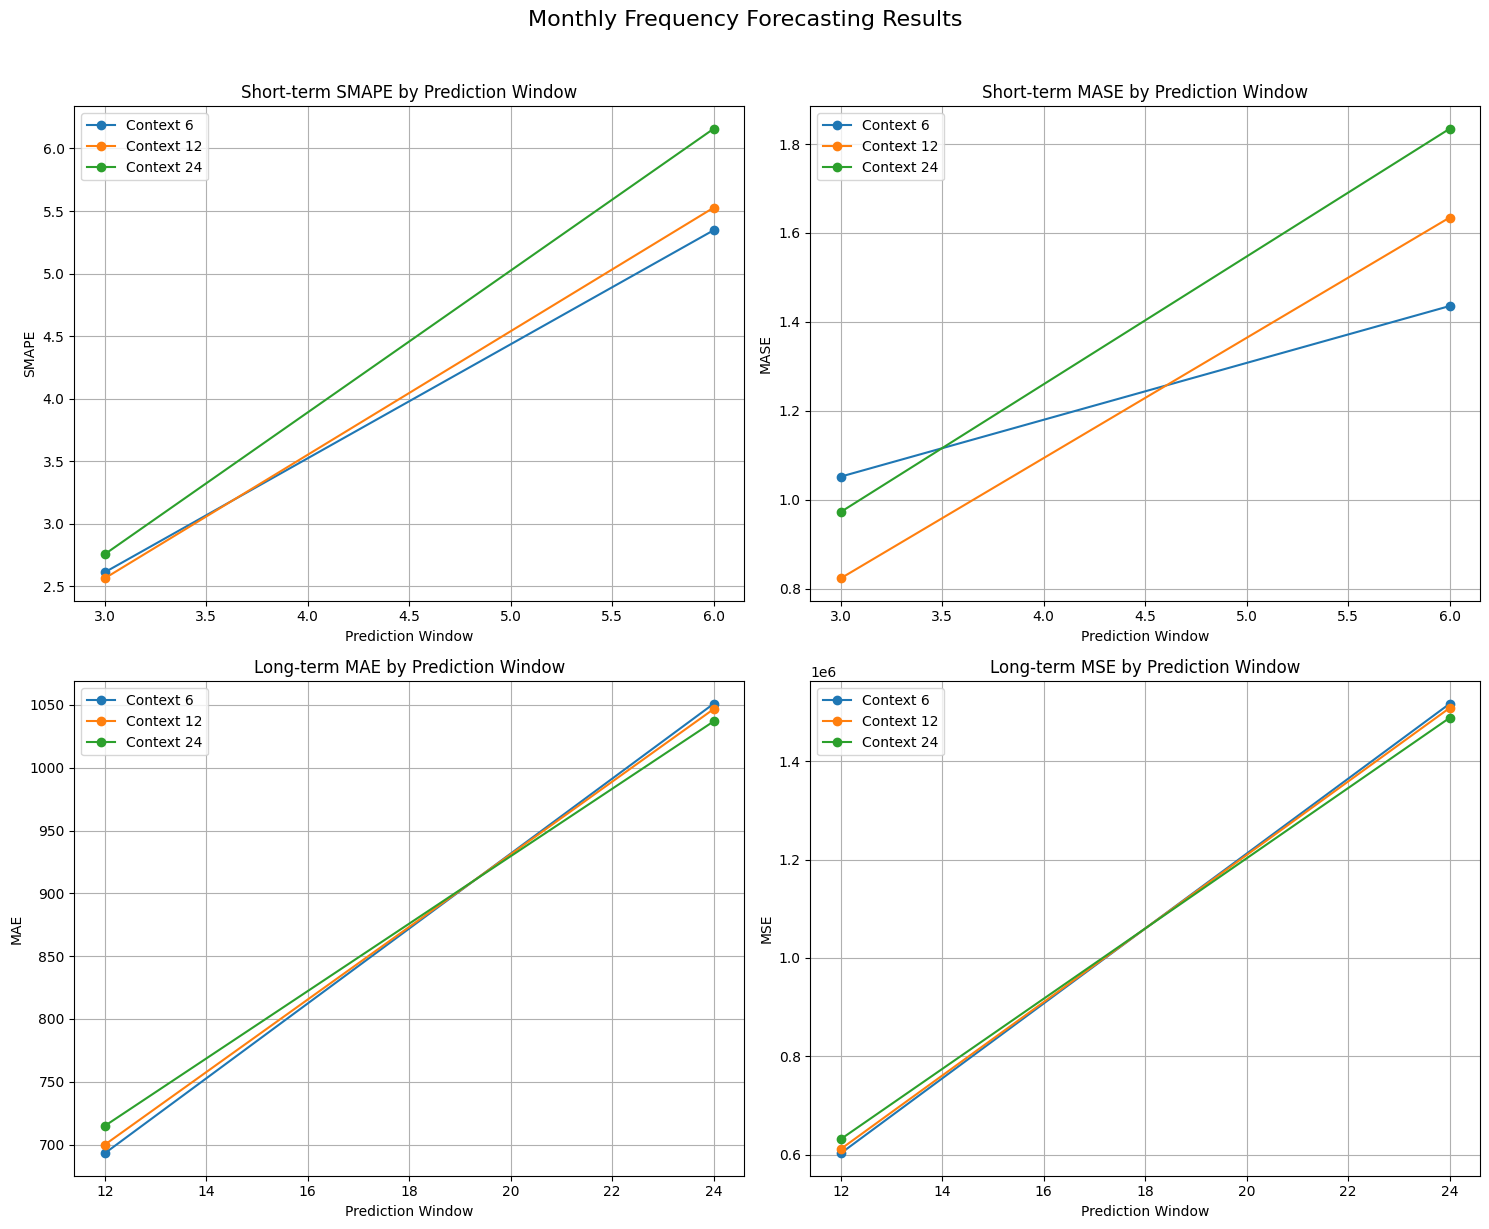


Monthly Frequency Results:

Short-term Forecasting Results:
Metric                                 MAE    MAPE    MASE          MSE  \
Context Window Prediction Window                                          
6              3                  152.9201  2.5716  1.0520   31348.3339   
               6                  302.1003  5.1702  1.4356  117812.3736   
12             3                  150.1551  2.5214  0.8234   31788.8698   
               6                  311.9357  5.3410  1.6346  124037.6777   
24             3                  161.2150  2.6986  0.9726   41155.3070   
               6                  346.2308  5.9326  1.8343  149508.1322   

Metric                                RMSE   SMAPE  
Context Window Prediction Window                    
6              3                  177.0546  2.6126  
               6                  343.2381  5.3459  
12             3                  178.2943  2.5646  
               6                  352.1898  5.5262  
24             3    

In [31]:
from data.snp500 import snp500_daily, snp500_monthly, snp500_weekly
from utils.evaluate import ContextPredictionWindowEvaluator

PATCH_SIZE = 8  # MOMENT uses patches of size 8 by default
SEQ_LEN = 512  # Default sequence length for MOMENT

def pad_to_patch_size(context, patch_size, seq_len=None):
    """Pad the input data to match MOMENT's requirements"""
    # If seq_len is specified, pad to that length
    if seq_len is not None:
        if len(context) > seq_len:
            return context[:seq_len]
        elif len(context) < seq_len:
            return np.pad(context, (0, seq_len - len(context)), mode='edge')
    
    # Otherwise, pad to next multiple of patch_size
    if len(context) % patch_size != 0:
        pad_length = patch_size - (len(context) % patch_size)
        return np.pad(context, (0, pad_length), mode='edge')
    return context

def generate_forecast(model, context, prediction_window):
    """Generate forecast with the given context and prediction window."""
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize the model if it is None
    if model is None:
        model = MOMENTPipeline.from_pretrained(
            "AutonLab/MOMENT-1-large",
            model_kwargs={
                'task_name': 'forecasting',
                'forecast_horizon': prediction_window,
                'head_dropout': 0.1,
                'weight_decay': 0,
                'freeze_encoder': True,
                'freeze_embedder': True,
                'freeze_head': False,
                'patch_size': PATCH_SIZE,
            },
        )
        model.init()
        model = model.to(device)

    # Normalize the context data
    context_mean = np.mean(context)
    context_std = np.std(context)
    context_normalized = (context - context_mean) / context_std

    # Pad the normalized context
    context_padded = pad_to_patch_size(context_normalized, PATCH_SIZE, seq_len=SEQ_LEN)
    
    # Prepare input tensor
    context_tensor = torch.from_numpy(context_padded).float().reshape(1, 1, -1).to(device)
    input_mask = torch.ones(context_tensor.shape[0], context_tensor.shape[2]).to(device)

    # Generate forecast
    with torch.no_grad():
        model.eval()
        output = model(x_enc=context_tensor, input_mask=input_mask)
        model.train()

    # Get mean forecast and denormalize
    mean_forecast = output.forecast.cpu().squeeze().numpy()
    mean_forecast = mean_forecast * context_std + context_mean

    # Ensure the forecast is the correct length
    if len(mean_forecast) > prediction_window:
        mean_forecast = mean_forecast[:prediction_window]
    elif len(mean_forecast) < prediction_window:
        mean_forecast = np.pad(mean_forecast, (0, prediction_window - len(mean_forecast)), mode='edge')

    # Calculate prediction intervals
    returns = np.diff(context) / context[:-1]
    volatility = np.std(returns)
    z_score_90 = 1.645  # 90% confidence interval
    interval_width = z_score_90 * volatility * mean_forecast

    low_forecast = mean_forecast - interval_width
    high_forecast = mean_forecast + interval_width

    return low_forecast, mean_forecast, high_forecast



def plot_results_by_frequency(results_df, frequency):
    """Create plots for short-term and long-term metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(
        f"{frequency.capitalize()} Frequency Forecasting Results", fontsize=16, y=1.02
    )

    # Short-term metrics (SMAPE and MASE)
    short_term = results_df[results_df["Horizon"] == "short_term"]
    context_windows = sorted(short_term["Context Window"].unique())

    # Plot SMAPE
    ax = axes[0, 0]
    for context in context_windows:
        data = short_term[
            (short_term["Context Window"] == context)
            & (short_term["Metric"] == "SMAPE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("SMAPE")
    ax.set_title("Short-term SMAPE by Prediction Window")
    ax.grid(True)
    ax.legend()

    # Plot MASE
    ax = axes[0, 1]
    for context in context_windows:
        data = short_term[
            (short_term["Context Window"] == context) & (short_term["Metric"] == "MASE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("MASE")
    ax.set_title("Short-term MASE by Prediction Window")
    ax.grid(True)
    ax.legend()

    # Long-term metrics (MAE and MSE)
    long_term = results_df[results_df["Horizon"] == "long_term"]

    # Plot MAE
    ax = axes[1, 0]
    for context in context_windows:
        data = long_term[
            (long_term["Context Window"] == context) & (long_term["Metric"] == "MAE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("MAE")
    ax.set_title("Long-term MAE by Prediction Window")
    ax.grid(True)
    ax.legend()

    # Plot MSE
    ax = axes[1, 1]
    for context in context_windows:
        data = long_term[
            (long_term["Context Window"] == context) & (long_term["Metric"] == "MSE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("MSE")
    ax.set_title("Long-term MSE by Prediction Window")
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()


# Initialize experiment runner with dummy model (will be recreated for each prediction)
dummy_model = None  # Model will be created dynamically in moirai_forecast

experiments = ContextPredictionWindowEvaluator(
    model=dummy_model, forecast_fn=generate_forecast
)

# Dictionary to store results for each frequency
frequency_results = {}

# Run experiments for each frequency
frequencies = {
    "daily": snp500_daily,
    "weekly": snp500_weekly,
    "monthly": snp500_monthly,
}

for freq, data in frequencies.items():
    print(f"\nRunning {freq} frequency experiments...")

    # Run experiments
    results = experiments.run_frequency_experiments(data, freq)
    frequency_results[freq] = results

    # Format results
    df_results = experiments.format_results(results)

    # Create visualizations
    plot_results_by_frequency(df_results, freq)

    # Create separate DataFrames for short-term and long-term results
    short_term_df = (
        df_results[df_results["Horizon"] == "short_term"]
        .pivot_table(
            index=["Context Window", "Prediction Window"],
            columns="Metric",
            values="Value",
        )
        .round(4)
    )

    long_term_df = (
        df_results[df_results["Horizon"] == "long_term"]
        .pivot_table(
            index=["Context Window", "Prediction Window"],
            columns="Metric",
            values="Value",
        )
        .round(4)
    )

    print(f"\n{freq.capitalize()} Frequency Results:")
    print("\nShort-term Forecasting Results:")
    print(short_term_df)
    print("\nLong-term Forecasting Results:")
    print(long_term_df)


# Forecasting visuals of best performing runs for recent and COVID-19 periods at different frequencies

## Long-term (Daily): {86, 192}

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_68269/4040441091.py:16: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")
/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/moment_venv/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


Context data shape (before padding): (96, 1)
Context padded shape: (512,)
Context tensor shape: torch.Size([1, 1, 512])
Input mask shape: torch.Size([1, 512])
Number of patches: 64

Full Period Metrics:
MAE: 389.7330
MSE: 215652.0327
RMSE: 464.3835
MAPE: 7.2883
SMAPE: 6.9263
MASE: 15.0293


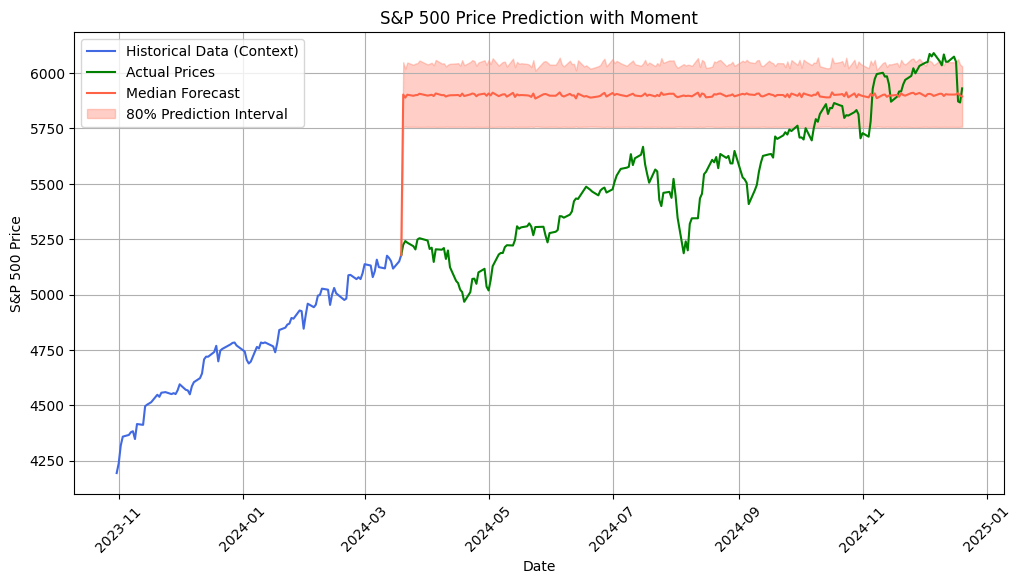

Context data shape (before padding): (96, 1)
Context padded shape: (512,)
Context tensor shape: torch.Size([1, 1, 512])
Input mask shape: torch.Size([1, 512])
Number of patches: 64

COVID Period Metrics:
MAE: 475.5660
MSE: 263897.0405
RMSE: 513.7091
MAPE: 10.6316
SMAPE: 11.3198
MASE: 18.3028


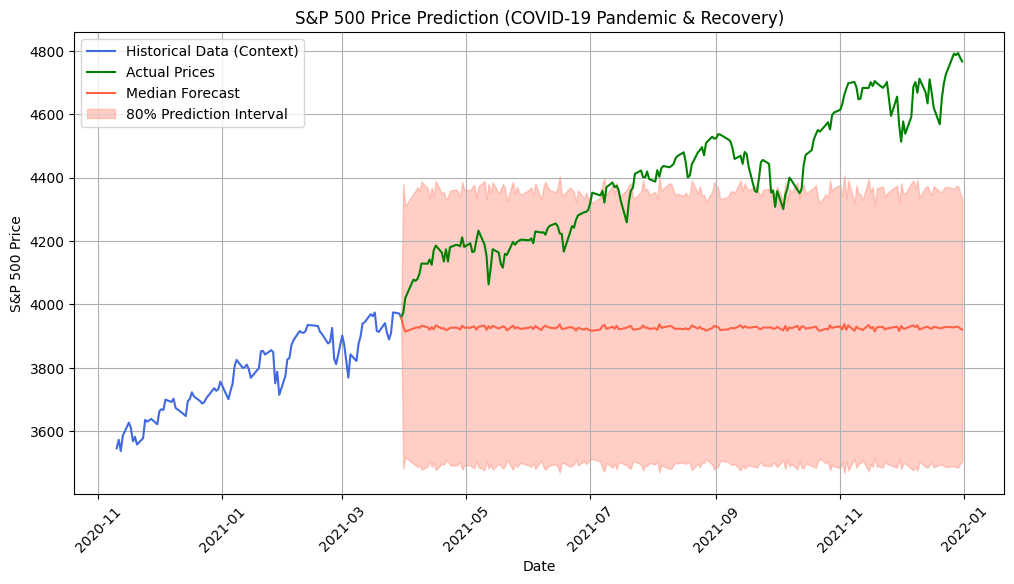

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from momentfm import MOMENTPipeline
from data.snp500 import snp500_daily
from utils.metrics import calculate_metrics
from utils.visualization import plot_forecast

CONTEXT_WINDOW = 96
PREDICTION_WINDOW = 192
PATCH_SIZE = 8  # MOMENT uses patches of size 8 by default
SEQ_LEN = 512  # Ensure sequence length matches the model's configuration

# Set device
device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")

# Initialize Moment model
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': PREDICTION_WINDOW,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True,
        'freeze_embedder': True,
        'freeze_head': False,
        'patch_size': PATCH_SIZE,
    },
)
model.init()
model = model.to(device)

# Prepare the data - using raw Close prices
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]

# Adjust patch size to match the expected input size of the model
def pad_to_patch_size(data, patch_size, seq_len):
    """Pad the input data to ensure it is divisible by patch_size and matches seq_len."""
    pad_length = max(seq_len - len(data), 0)  # Ensure length matches seq_len
    return np.pad(data, (0, pad_length), mode="edge")

# Update generate_forecast to ensure proper reshaping
def generate_forecast(context_data):
    context = np.asarray(context_data).flatten()
    context_padded = pad_to_patch_size(context, PATCH_SIZE, seq_len=SEQ_LEN)

    # Debug prints for shape verification
    print(f"Context data shape (before padding): {context_data.shape}")
    print(f"Context padded shape: {context_padded.shape}")

    # Ensure the reshaped input matches the model's expectation
    context_tensor = torch.from_numpy(context_padded).float().reshape(1, 1, -1).to(device)
    input_mask = torch.ones(context_tensor.shape[0], context_tensor.shape[2]).to(device)

    print(f"Context tensor shape: {context_tensor.shape}")
    print(f"Input mask shape: {input_mask.shape}")
    print(f"Number of patches: {context_tensor.shape[2] // PATCH_SIZE}")

    with torch.no_grad():
        model.eval()
        output = model(x_enc=context_tensor, input_mask=input_mask)
        model.train()

    mean_forecast = output.forecast.cpu().squeeze().numpy()

    # Calculate prediction intervals (as before)
    returns = np.diff(context_padded) / context_padded[:-1]
    volatility = np.std(returns)
    z_score_90 = 1.645
    interval_width = z_score_90 * volatility * mean_forecast

    low_forecast = mean_forecast - interval_width
    high_forecast = mean_forecast + interval_width

    return low_forecast, mean_forecast, high_forecast

def normalize_data(data):
    """Normalize the input data"""
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std, mean, std

def denormalize_data(data, mean, std):
    """Denormalize the data back to original scale"""
    return data * std + mean

# Generate full period forecast
context = sp500_d["Close"].values[-CONTEXT_WINDOW:]
context_norm, mean, std = normalize_data(context)
low, median, high = generate_forecast(context_norm)

# Denormalize predictions
low = denormalize_data(low, mean, std)
median = denormalize_data(median, mean, std)
high = denormalize_data(high, mean, std)

# Calculate and print metrics for full period
actual_prices = sp500_d["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_d["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_d,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with Moment",
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_d[
    (sp500_d["Date"] >= covid_start_date) & (sp500_d["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)

covid_context_norm, covid_mean, covid_std = normalize_data(covid_context)
low_covid, median_covid, high_covid = generate_forecast(covid_context_norm)

# Denormalize predictions
low_covid = denormalize_data(low_covid, covid_mean, covid_std)
median_covid = denormalize_data(median_covid, covid_mean, covid_std)
high_covid = denormalize_data(high_covid, covid_mean, covid_std)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)

# Short-term (Daily): {96, 48}

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_68269/576612923.py:16: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")
/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/moment_venv/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


Context data shape (before padding): (96, 1)
Context padded shape: (512,)
Context tensor shape: torch.Size([1, 1, 512])
Input mask shape: torch.Size([1, 512])
Number of patches: 64

Full Period Metrics:
MAE: 96.9254
MSE: 12650.9175
RMSE: 112.4763
MAPE: 1.6296
SMAPE: 1.6360
MASE: 2.6960


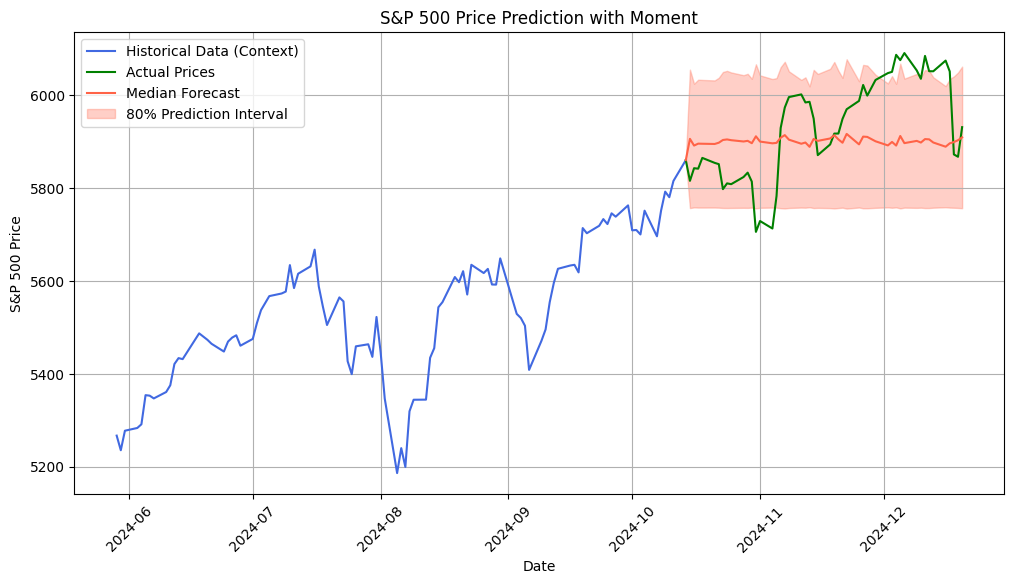

Context data shape (before padding): (96, 1)
Context padded shape: (512,)
Context tensor shape: torch.Size([1, 1, 512])
Input mask shape: torch.Size([1, 512])
Number of patches: 64

COVID Period Metrics:
MAE: 145.1968
MSE: 25596.9740
RMSE: 159.9905
MAPE: 3.0948
SMAPE: 3.1537
MASE: 6.1620


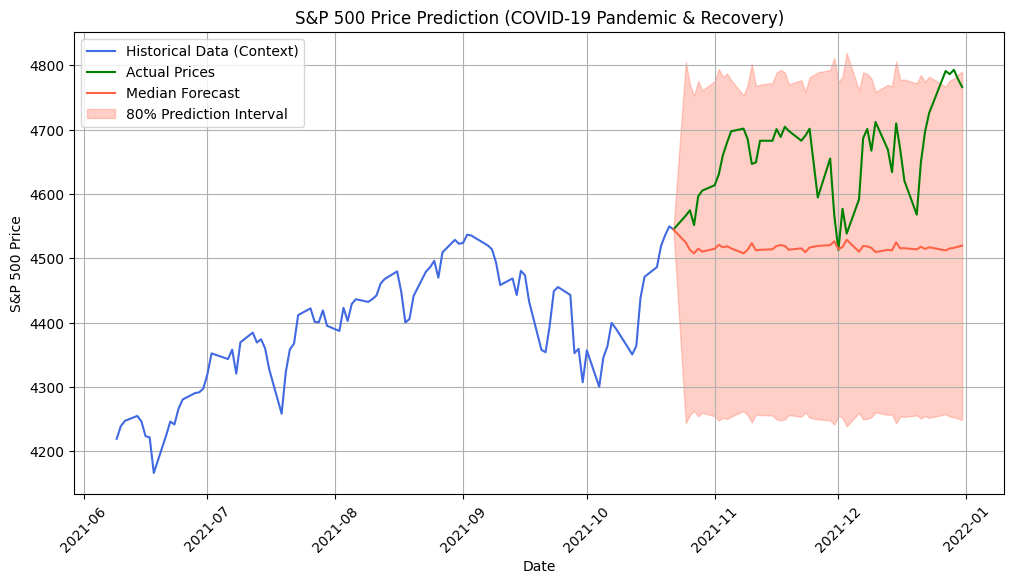

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from momentfm import MOMENTPipeline
from data.snp500 import snp500_daily
from utils.metrics import calculate_metrics
from utils.visualization import plot_forecast

CONTEXT_WINDOW = 96
PREDICTION_WINDOW = 48
PATCH_SIZE = 8  # MOMENT uses patches of size 8 by default
SEQ_LEN = 512  # Ensure sequence length matches the model's configuration

# Set device
device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")

# Initialize Moment model
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': PREDICTION_WINDOW,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True,
        'freeze_embedder': True,
        'freeze_head': False,
        'patch_size': PATCH_SIZE,
    },
)
model.init()
model = model.to(device)

# Prepare the data - using raw Close prices
sp500_d = snp500_weekly.reset_index()[["Date", "Close"]]

# Adjust patch size to match the expected input size of the model
def pad_to_patch_size(data, patch_size, seq_len):
    """Pad the input data to ensure it is divisible by patch_size and matches seq_len."""
    pad_length = max(seq_len - len(data), 0)  # Ensure length matches seq_len
    return np.pad(data, (0, pad_length), mode="edge")

# Update generate_forecast to ensure proper reshaping
def generate_forecast(context_data):
    context = np.asarray(context_data).flatten()
    context_padded = pad_to_patch_size(context, PATCH_SIZE, seq_len=SEQ_LEN)

    # Debug prints for shape verification
    print(f"Context data shape (before padding): {context_data.shape}")
    print(f"Context padded shape: {context_padded.shape}")

    # Ensure the reshaped input matches the model's expectation
    context_tensor = torch.from_numpy(context_padded).float().reshape(1, 1, -1).to(device)
    input_mask = torch.ones(context_tensor.shape[0], context_tensor.shape[2]).to(device)

    print(f"Context tensor shape: {context_tensor.shape}")
    print(f"Input mask shape: {input_mask.shape}")
    print(f"Number of patches: {context_tensor.shape[2] // PATCH_SIZE}")

    with torch.no_grad():
        model.eval()
        output = model(x_enc=context_tensor, input_mask=input_mask)
        model.train()

    mean_forecast = output.forecast.cpu().squeeze().numpy()

    # Calculate prediction intervals (as before)
    returns = np.diff(context_padded) / context_padded[:-1]
    volatility = np.std(returns)
    z_score_90 = 1.645
    interval_width = z_score_90 * volatility * mean_forecast

    low_forecast = mean_forecast - interval_width
    high_forecast = mean_forecast + interval_width

    return low_forecast, mean_forecast, high_forecast

def normalize_data(data):
    """Normalize the input data"""
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std, mean, std

def denormalize_data(data, mean, std):
    """Denormalize the data back to original scale"""
    return data * std + mean

# Generate full period forecast
context = sp500_d["Close"].values[-CONTEXT_WINDOW:]
context_norm, mean, std = normalize_data(context)
low, median, high = generate_forecast(context_norm)

# Denormalize predictions
low = denormalize_data(low, mean, std)
median = denormalize_data(median, mean, std)
high = denormalize_data(high, mean, std)

# Calculate and print metrics for full period
actual_prices = sp500_d["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_d["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_d,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with Moment",
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_d[
    (sp500_d["Date"] >= covid_start_date) & (sp500_d["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)

covid_context_norm, covid_mean, covid_std = normalize_data(covid_context)
low_covid, median_covid, high_covid = generate_forecast(covid_context_norm)

# Denormalize predictions
low_covid = denormalize_data(low_covid, covid_mean, covid_std)
median_covid = denormalize_data(median_covid, covid_mean, covid_std)
high_covid = denormalize_data(high_covid, covid_mean, covid_std)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)

## Long-term (Weekly): {12, 48}

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_68269/2442633344.py:14: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")
/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/moment_venv/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


Context data shape (before padding): (12, 1)
Context padded shape: (512,)
Context tensor shape: torch.Size([1, 1, 512])
Input mask shape: torch.Size([1, 512])
Number of patches: 64

Full Period Metrics:
MAE: 487.5086
MSE: 327352.4514
RMSE: 572.1472
MAPE: 9.2823
SMAPE: 8.7145
MASE: 8.5576


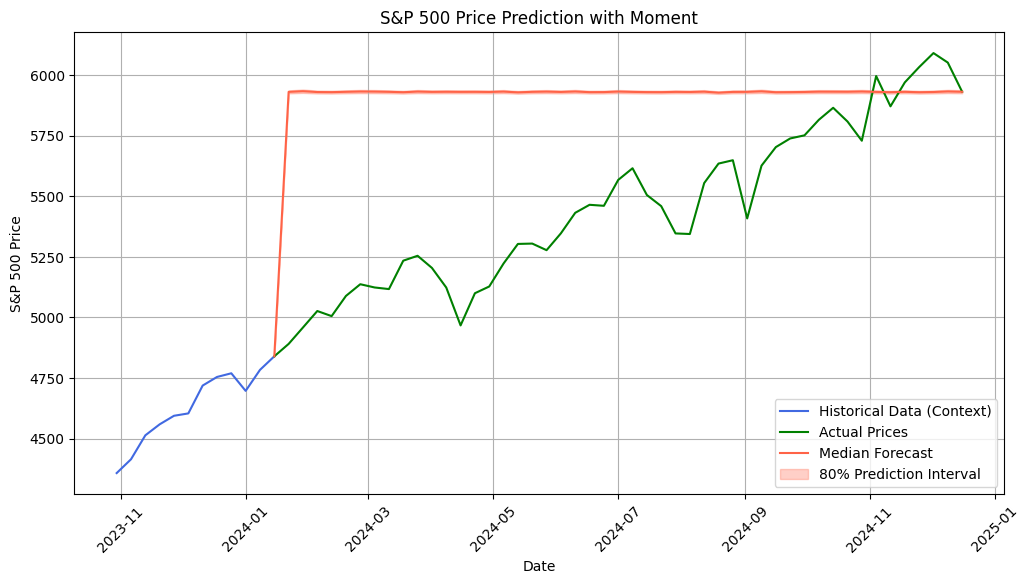

Context data shape (before padding): (12, 1)
Context padded shape: (512,)
Context tensor shape: torch.Size([1, 1, 512])
Input mask shape: torch.Size([1, 512])
Number of patches: 64

COVID Period Metrics:
MAE: 611.0330
MSE: 440531.6876
RMSE: 663.7256
MAPE: 13.8125
SMAPE: 15.0079
MASE: 10.5740


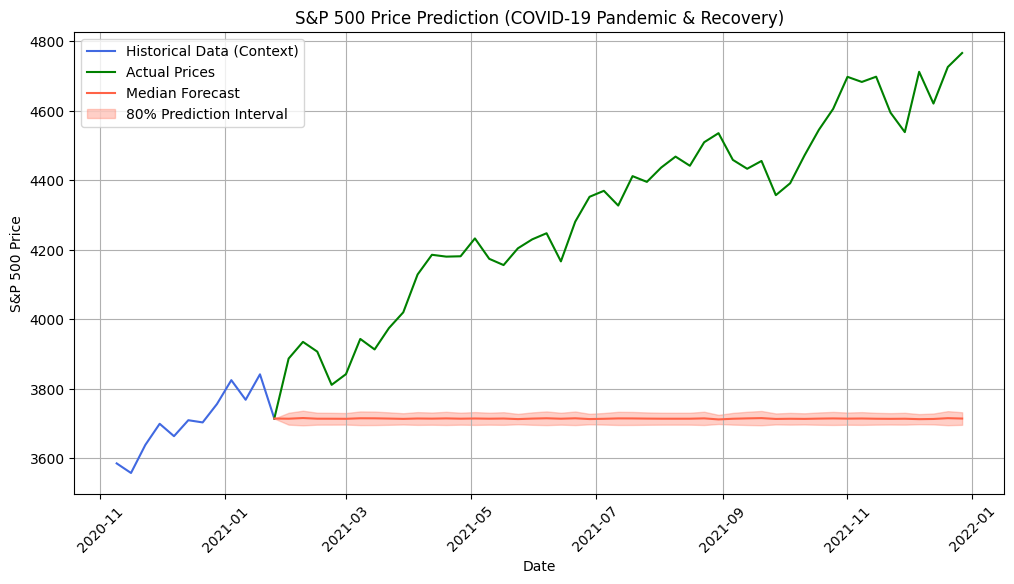

In [48]:
import numpy as np
import torch
from momentfm import MOMENTPipeline
from data.snp500 import snp500_weekly
from utils.metrics import calculate_metrics
from utils.visualization import plot_forecast

CONTEXT_WINDOW = 12
PREDICTION_WINDOW = 48
PATCH_SIZE = 8  # MOMENT uses patches of size 8 by default
SEQ_LEN = 512  # Ensure sequence length matches the model's configuration

# Set device
device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")

# Initialize Moment model
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': PREDICTION_WINDOW,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True,
        'freeze_embedder': True,
        'freeze_head': False,
        'patch_size': PATCH_SIZE,
    },
)
model.init()
model = model.to(device)

# Prepare the data - using raw Close prices
sp500_w = snp500_weekly.reset_index()[["Date", "Close"]]

# Adjust patch size to match the expected input size of the model
def pad_to_patch_size(data, patch_size, seq_len):
    """Pad the input data to ensure it is divisible by patch_size and matches seq_len."""
    pad_length = max(seq_len - len(data), 0)  # Ensure length matches seq_len
    return np.pad(data, (0, pad_length), mode="edge")

# Update generate_forecast to ensure proper reshaping
def generate_forecast(context_data):
    context = np.asarray(context_data).flatten()
    context_padded = pad_to_patch_size(context, PATCH_SIZE, seq_len=SEQ_LEN)

    # Debug prints for shape verification
    print(f"Context data shape (before padding): {context_data.shape}")
    print(f"Context padded shape: {context_padded.shape}")

    # Ensure the reshaped input matches the model's expectation
    context_tensor = torch.from_numpy(context_padded).float().reshape(1, 1, -1).to(device)
    input_mask = torch.ones(context_tensor.shape[0], context_tensor.shape[2]).to(device)

    print(f"Context tensor shape: {context_tensor.shape}")
    print(f"Input mask shape: {input_mask.shape}")
    print(f"Number of patches: {context_tensor.shape[2] // PATCH_SIZE}")

    with torch.no_grad():
        model.eval()
        output = model(x_enc=context_tensor, input_mask=input_mask)
        model.train()

    mean_forecast = output.forecast.cpu().squeeze().numpy()

    # Calculate prediction intervals (as before)
    returns = np.diff(context_padded) / context_padded[:-1]
    volatility = np.std(returns)
    z_score_90 = 1.645
    interval_width = z_score_90 * volatility * mean_forecast

    low_forecast = mean_forecast - interval_width
    high_forecast = mean_forecast + interval_width

    return low_forecast, mean_forecast, high_forecast

def normalize_data(data):
    """Normalize the input data"""
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std, mean, std

def denormalize_data(data, mean, std):
    """Denormalize the data back to original scale"""
    return data * std + mean

# Generate full period forecast
context = sp500_w["Close"].values[-CONTEXT_WINDOW:]
context_norm, mean, std = normalize_data(context)
low, median, high = generate_forecast(context_norm)

# Denormalize predictions
low = denormalize_data(low, mean, std)
median = denormalize_data(median, mean, std)
high = denormalize_data(high, mean, std)

# Calculate and print metrics for full period
actual_prices = sp500_w["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_w["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_w,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with Moment",
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_w[
    (sp500_w["Date"] >= covid_start_date) & (sp500_w["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)

covid_context_norm, covid_mean, covid_std = normalize_data(covid_context)
low_covid, median_covid, high_covid = generate_forecast(covid_context_norm)

# Denormalize predictions
low_covid = denormalize_data(low_covid, covid_mean, covid_std)
median_covid = denormalize_data(median_covid, covid_mean, covid_std)
high_covid = denormalize_data(high_covid, covid_mean, covid_std)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)

## Short-term (Weekly): {12, 12}

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_68269/3708498028.py:14: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")
/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/moment_venv/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


Context data shape (before padding): (12, 1)
Context padded shape: (512,)
Context tensor shape: torch.Size([1, 1, 512])
Input mask shape: torch.Size([1, 512])
Number of patches: 64

Full Period Metrics:
MAE: 102.9197
MSE: 13818.0562
RMSE: 117.5502
MAPE: 1.7490
SMAPE: 1.7420
MASE: 0.9886


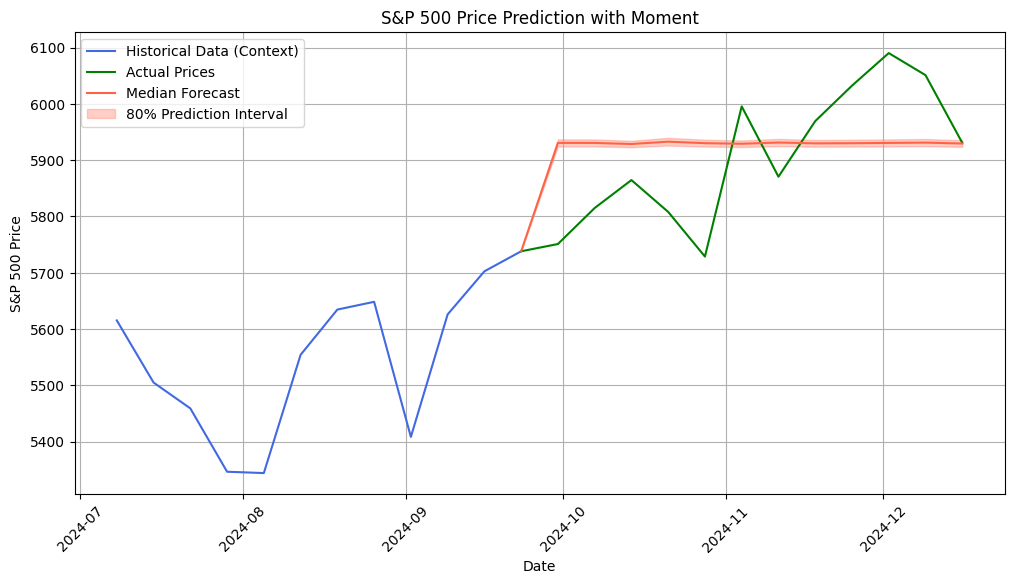

Context data shape (before padding): (12, 1)
Context padded shape: (512,)
Context tensor shape: torch.Size([1, 1, 512])
Input mask shape: torch.Size([1, 512])
Number of patches: 64

COVID Period Metrics:
MAE: 245.8279
MSE: 67772.6065
RMSE: 260.3317
MAPE: 5.2675
SMAPE: 5.4268
MASE: 5.7900


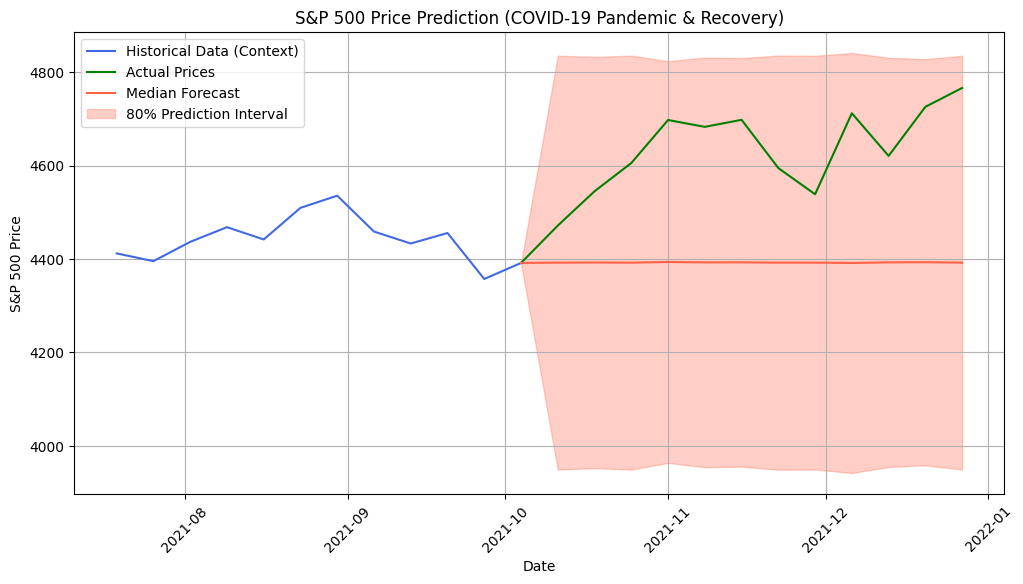

In [49]:
import numpy as np
import torch
from momentfm import MOMENTPipeline
from data.snp500 import snp500_weekly
from utils.metrics import calculate_metrics
from utils.visualization import plot_forecast

CONTEXT_WINDOW = 12
PREDICTION_WINDOW = 12
PATCH_SIZE = 8  # MOMENT uses patches of size 8 by default
SEQ_LEN = 512  # Ensure sequence length matches the model's configuration

# Set device
device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")

# Initialize Moment model
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': PREDICTION_WINDOW,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True,
        'freeze_embedder': True,
        'freeze_head': False,
        'patch_size': PATCH_SIZE,
    },
)
model.init()
model = model.to(device)

# Prepare the data - using raw Close prices
sp500_w = snp500_weekly.reset_index()[["Date", "Close"]]

# Adjust patch size to match the expected input size of the model
def pad_to_patch_size(data, patch_size, seq_len):
    """Pad the input data to ensure it is divisible by patch_size and matches seq_len."""
    pad_length = max(seq_len - len(data), 0)  # Ensure length matches seq_len
    return np.pad(data, (0, pad_length), mode="edge")

# Update generate_forecast to ensure proper reshaping
def generate_forecast(context_data):
    context = np.asarray(context_data).flatten()
    context_padded = pad_to_patch_size(context, PATCH_SIZE, seq_len=SEQ_LEN)

    # Debug prints for shape verification
    print(f"Context data shape (before padding): {context_data.shape}")
    print(f"Context padded shape: {context_padded.shape}")

    # Ensure the reshaped input matches the model's expectation
    context_tensor = torch.from_numpy(context_padded).float().reshape(1, 1, -1).to(device)
    input_mask = torch.ones(context_tensor.shape[0], context_tensor.shape[2]).to(device)

    print(f"Context tensor shape: {context_tensor.shape}")
    print(f"Input mask shape: {input_mask.shape}")
    print(f"Number of patches: {context_tensor.shape[2] // PATCH_SIZE}")

    with torch.no_grad():
        model.eval()
        output = model(x_enc=context_tensor, input_mask=input_mask)
        model.train()

    mean_forecast = output.forecast.cpu().squeeze().numpy()

    # Calculate prediction intervals (as before)
    returns = np.diff(context_padded) / context_padded[:-1]
    volatility = np.std(returns)
    z_score_90 = 1.645
    interval_width = z_score_90 * volatility * mean_forecast

    low_forecast = mean_forecast - interval_width
    high_forecast = mean_forecast + interval_width

    return low_forecast, mean_forecast, high_forecast

def normalize_data(data):
    """Normalize the input data"""
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std, mean, std

def denormalize_data(data, mean, std):
    """Denormalize the data back to original scale"""
    return data * std + mean

# Generate full period forecast
context = sp500_w["Close"].values[-CONTEXT_WINDOW:]
context_norm, mean, std = normalize_data(context)
low, median, high = generate_forecast(context_norm)

# Denormalize predictions
low = denormalize_data(low, mean, std)
median = denormalize_data(median, mean, std)
high = denormalize_data(high, mean, std)

# Calculate and print metrics for full period
actual_prices = sp500_w["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_w["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_w,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with Moment",
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_w[
    (sp500_w["Date"] >= covid_start_date) & (sp500_w["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)

covid_context_norm, covid_mean, covid_std = normalize_data(covid_context)
low_covid, median_covid, high_covid = generate_forecast(covid_context_norm)

# Denormalize predictions
low_covid = denormalize_data(low_covid, covid_mean, covid_std)
median_covid = denormalize_data(median_covid, covid_mean, covid_std)
high_covid = denormalize_data(high_covid, covid_mean, covid_std)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)

## Long-term (Monthly): {6, 12}

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_68269/2866304605.py:14: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")
/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/moment_venv/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


Context data shape (before padding): (6, 1)
Context padded shape: (512,)
Context tensor shape: torch.Size([1, 1, 512])
Input mask shape: torch.Size([1, 512])
Number of patches: 64

Full Period Metrics:
MAE: 445.4666
MSE: 298044.5859
RMSE: 545.9346
MAPE: 8.5608
SMAPE: 8.0323
MASE: 2.2934


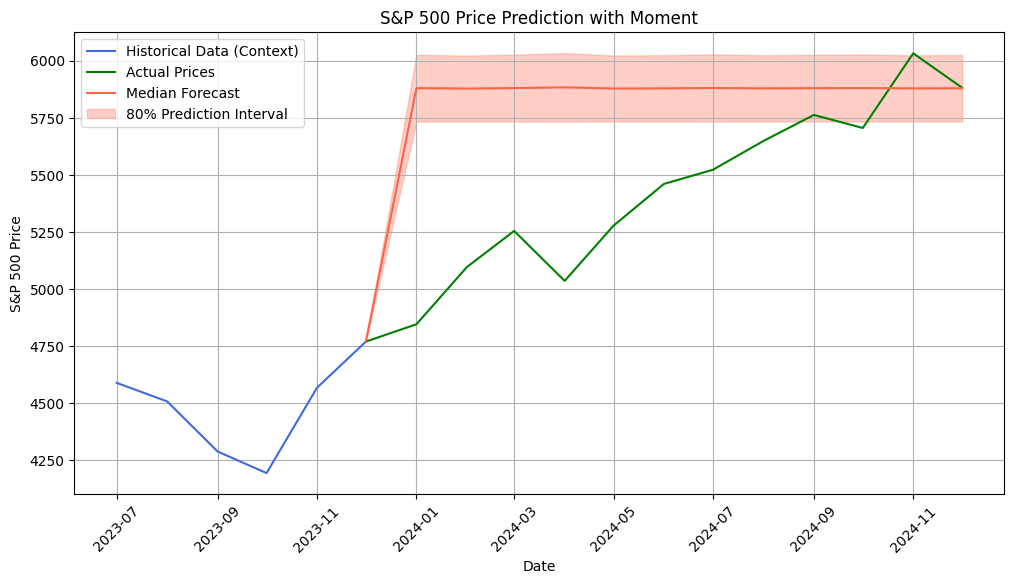

Context data shape (before padding): (6, 1)
Context padded shape: (512,)
Context tensor shape: torch.Size([1, 1, 512])
Input mask shape: torch.Size([1, 512])
Number of patches: 64

COVID Period Metrics:
MAE: 533.1707
MSE: 373376.9552
RMSE: 611.0458
MAPE: 12.0080
SMAPE: 13.0086
MASE: 2.8191


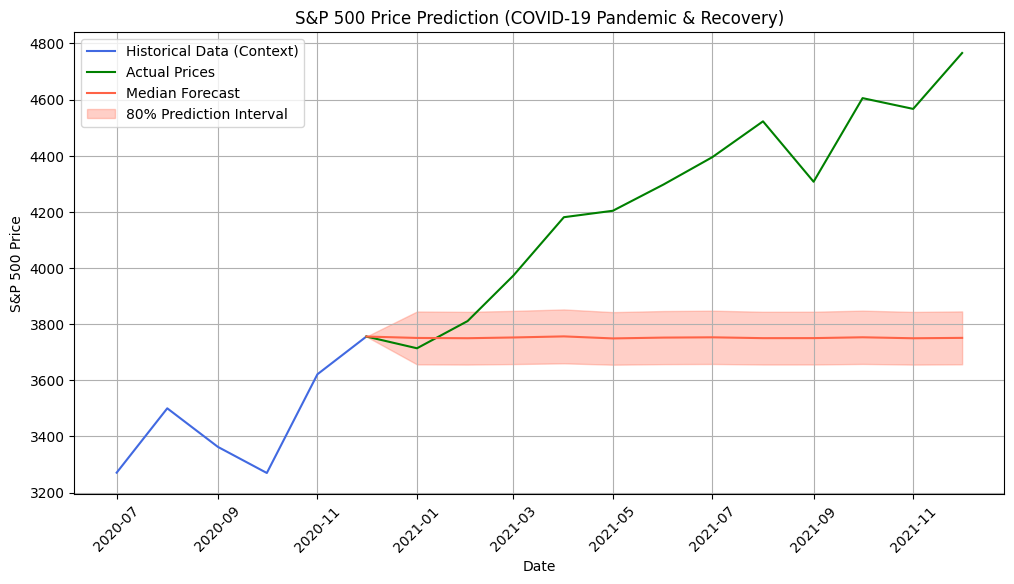

In [50]:
import numpy as np
import torch
from momentfm import MOMENTPipeline
from data.snp500 import snp500_monthly
from utils.metrics import calculate_metrics
from utils.visualization import plot_forecast

CONTEXT_WINDOW = 6
PREDICTION_WINDOW = 12
PATCH_SIZE = 8  # MOMENT uses patches of size 8 by default
SEQ_LEN = 512  # Ensure sequence length matches the model's configuration

# Set device
device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")

# Initialize Moment model
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': PREDICTION_WINDOW,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True,
        'freeze_embedder': True,
        'freeze_head': False,
        'patch_size': PATCH_SIZE,
    },
)
model.init()
model = model.to(device)

# Prepare the data - using raw Close prices
sp500_m = snp500_monthly.reset_index()[["Date", "Close"]]

# Adjust patch size to match the expected input size of the model
def pad_to_patch_size(data, patch_size, seq_len):
    """Pad the input data to ensure it is divisible by patch_size and matches seq_len."""
    pad_length = max(seq_len - len(data), 0)  # Ensure length matches seq_len
    return np.pad(data, (0, pad_length), mode="edge")

# Update generate_forecast to ensure proper reshaping
def generate_forecast(context_data):
    context = np.asarray(context_data).flatten()
    context_padded = pad_to_patch_size(context, PATCH_SIZE, seq_len=SEQ_LEN)

    # Debug prints for shape verification
    print(f"Context data shape (before padding): {context_data.shape}")
    print(f"Context padded shape: {context_padded.shape}")

    # Ensure the reshaped input matches the model's expectation
    context_tensor = torch.from_numpy(context_padded).float().reshape(1, 1, -1).to(device)
    input_mask = torch.ones(context_tensor.shape[0], context_tensor.shape[2]).to(device)

    print(f"Context tensor shape: {context_tensor.shape}")
    print(f"Input mask shape: {input_mask.shape}")
    print(f"Number of patches: {context_tensor.shape[2] // PATCH_SIZE}")

    with torch.no_grad():
        model.eval()
        output = model(x_enc=context_tensor, input_mask=input_mask)
        model.train()

    mean_forecast = output.forecast.cpu().squeeze().numpy()

    # Calculate prediction intervals (as before)
    returns = np.diff(context_padded) / context_padded[:-1]
    volatility = np.std(returns)
    z_score_90 = 1.645
    interval_width = z_score_90 * volatility * mean_forecast

    low_forecast = mean_forecast - interval_width
    high_forecast = mean_forecast + interval_width

    return low_forecast, mean_forecast, high_forecast

def normalize_data(data):
    """Normalize the input data"""
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std, mean, std

def denormalize_data(data, mean, std):
    """Denormalize the data back to original scale"""
    return data * std + mean

# Generate full period forecast
context = sp500_m["Close"].values[-CONTEXT_WINDOW:]
context_norm, mean, std = normalize_data(context)
low, median, high = generate_forecast(context_norm)

# Denormalize predictions
low = denormalize_data(low, mean, std)
median = denormalize_data(median, mean, std)
high = denormalize_data(high, mean, std)

# Calculate and print metrics for full period
actual_prices = sp500_m["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_m["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_m,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with Moment",
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_m[
    (sp500_m["Date"] >= covid_start_date) & (sp500_m["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)

covid_context_norm, covid_mean, covid_std = normalize_data(covid_context)
low_covid, median_covid, high_covid = generate_forecast(covid_context_norm)

# Denormalize predictions
low_covid = denormalize_data(low_covid, covid_mean, covid_std)
median_covid = denormalize_data(median_covid, covid_mean, covid_std)
high_covid = denormalize_data(high_covid, covid_mean, covid_std)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)

## Short-term (Monthly): {12, 3}

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_68269/1460445137.py:14: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")
/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/moment_venv/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


Context data shape (before padding): (12, 1)
Context padded shape: (512,)
Context tensor shape: torch.Size([1, 1, 512])
Input mask shape: torch.Size([1, 512])
Number of patches: 64

Full Period Metrics:
MAE: 111.2648
MSE: 18003.3889
RMSE: 134.1767
MAPE: 1.8997
SMAPE: 1.8961
MASE: 0.6101


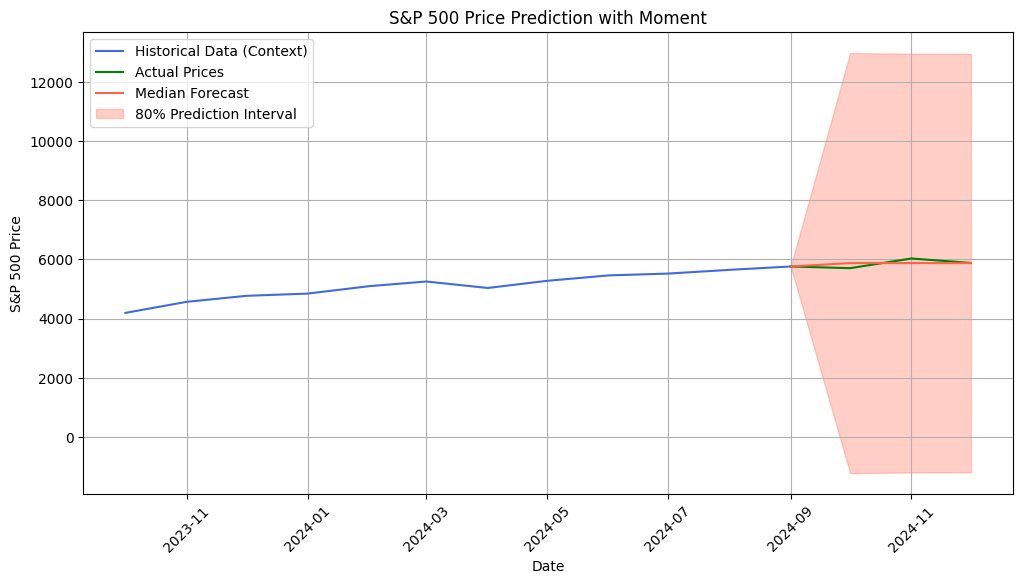

Context data shape (before padding): (12, 1)
Context padded shape: (512,)
Context tensor shape: torch.Size([1, 1, 512])
Input mask shape: torch.Size([1, 512])
Number of patches: 64

COVID Period Metrics:
MAE: 341.3660
MSE: 123984.8639
RMSE: 352.1148
MAPE: 7.3156
SMAPE: 7.6097
MASE: 2.4202


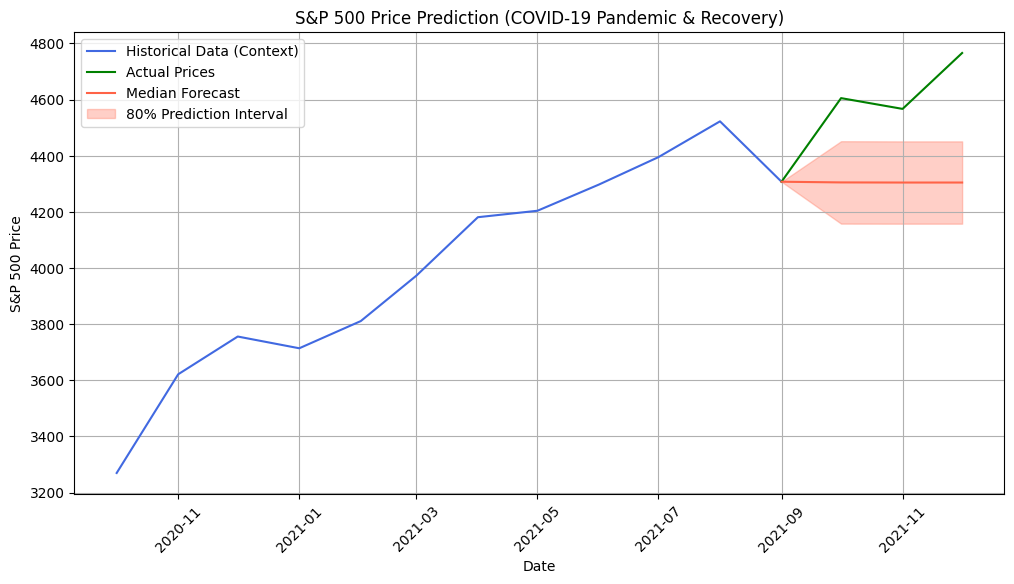

In [51]:
import numpy as np
import torch
from momentfm import MOMENTPipeline
from data.snp500 import snp500_monthly
from utils.metrics import calculate_metrics
from utils.visualization import plot_forecast

CONTEXT_WINDOW = 12
PREDICTION_WINDOW = 3
PATCH_SIZE = 8  # MOMENT uses patches of size 8 by default
SEQ_LEN = 512  # Ensure sequence length matches the model's configuration

# Set device
device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")

# Initialize Moment model
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': PREDICTION_WINDOW,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True,
        'freeze_embedder': True,
        'freeze_head': False,
        'patch_size': PATCH_SIZE,
    },
)
model.init()
model = model.to(device)

# Prepare the data - using raw Close prices
sp500_m = snp500_monthly.reset_index()[["Date", "Close"]]

# Adjust patch size to match the expected input size of the model
def pad_to_patch_size(data, patch_size, seq_len):
    """Pad the input data to ensure it is divisible by patch_size and matches seq_len."""
    pad_length = max(seq_len - len(data), 0)  # Ensure length matches seq_len
    return np.pad(data, (0, pad_length), mode="edge")

# Update generate_forecast to ensure proper reshaping
def generate_forecast(context_data):
    context = np.asarray(context_data).flatten()
    context_padded = pad_to_patch_size(context, PATCH_SIZE, seq_len=SEQ_LEN)

    # Debug prints for shape verification
    print(f"Context data shape (before padding): {context_data.shape}")
    print(f"Context padded shape: {context_padded.shape}")

    # Ensure the reshaped input matches the model's expectation
    context_tensor = torch.from_numpy(context_padded).float().reshape(1, 1, -1).to(device)
    input_mask = torch.ones(context_tensor.shape[0], context_tensor.shape[2]).to(device)

    print(f"Context tensor shape: {context_tensor.shape}")
    print(f"Input mask shape: {input_mask.shape}")
    print(f"Number of patches: {context_tensor.shape[2] // PATCH_SIZE}")

    with torch.no_grad():
        model.eval()
        output = model(x_enc=context_tensor, input_mask=input_mask)
        model.train()

    mean_forecast = output.forecast.cpu().squeeze().numpy()

    # Calculate prediction intervals (as before)
    returns = np.diff(context_padded) / context_padded[:-1]
    volatility = np.std(returns)
    z_score_90 = 1.645
    interval_width = z_score_90 * volatility * mean_forecast

    low_forecast = mean_forecast - interval_width
    high_forecast = mean_forecast + interval_width

    return low_forecast, mean_forecast, high_forecast

def normalize_data(data):
    """Normalize the input data"""
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std, mean, std

def denormalize_data(data, mean, std):
    """Denormalize the data back to original scale"""
    return data * std + mean

# Generate full period forecast
context = sp500_m["Close"].values[-CONTEXT_WINDOW:]
context_norm, mean, std = normalize_data(context)
low, median, high = generate_forecast(context_norm)

# Denormalize predictions
low = denormalize_data(low, mean, std)
median = denormalize_data(median, mean, std)
high = denormalize_data(high, mean, std)

# Calculate and print metrics for full period
actual_prices = sp500_m["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_m["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_m,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with Moment",
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_m[
    (sp500_m["Date"] >= covid_start_date) & (sp500_m["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)

covid_context_norm, covid_mean, covid_std = normalize_data(covid_context)
low_covid, median_covid, high_covid = generate_forecast(covid_context_norm)

# Denormalize predictions
low_covid = denormalize_data(low_covid, covid_mean, covid_std)
median_covid = denormalize_data(median_covid, covid_mean, covid_std)
high_covid = denormalize_data(high_covid, covid_mean, covid_std)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)